# 0. Import packages

In [1]:
import cv2
import json
import umap
import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# 1. Load image embedding from layer activation

In [2]:
def get_path_img_emb_from_layer_act(model_nickname, layer, dim=None):
    if dim is None:
        return f'/raid/NeuEvo/data/layer_act/{model_nickname}/data/{layer}/img_emb.txt'
    else:
        return f'/raid/NeuEvo/data/layer_act/{model_nickname}/data/{layer}/img_emb-dim={dim}.txt'

def load_img_emb_from_layer_act(model_nickname, layer, dim):
    p = get_path_img_emb_from_layer_act(model_nickname, layer, dim)
    data = np.loadtxt(p)
    return data

In [3]:
model_nickname = 'vgg19_pretrained'
layers = [
    # 'Sequential_0_Conv2d_0',
    # 'Sequential_0_Conv2d_2',
    # 'Sequential_0_Conv2d_5',
    'Sequential_0_Conv2d_7',
    # 'Sequential_0_Conv2d_10',
    # 'Sequential_0_Conv2d_12',
    # 'Sequential_0_Conv2d_14',
    'Sequential_0_Conv2d_16',
    # 'Sequential_0_Conv2d_19',
    # 'Sequential_0_Conv2d_21',
    # 'Sequential_0_Conv2d_23',
    'Sequential_0_Conv2d_25',
    # 'Sequential_0_Conv2d_28',
    # 'Sequential_0_Conv2d_30',
    # 'Sequential_0_Conv2d_32',
    'Sequential_0_Conv2d_34'
]

layer_acts = {}
with tqdm(total=len(layers)) as pbar:
    for layer in layers:
        layer_acts[layer] = load_img_emb_from_layer_act(model_nickname, layer, dim=None)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [11:11<00:00, 167.87s/it]


In [4]:
for layer in layers:
    print(f'{layer}: {layer_acts[layer].shape}')

Sequential_0_Conv2d_7: (1281167, 128)
Sequential_0_Conv2d_16: (1281167, 256)
Sequential_0_Conv2d_25: (1281167, 512)
Sequential_0_Conv2d_34: (1281167, 512)


In [5]:
num_imgs = 1281167

# 2. For each image, find k most activated neurons 

## 2-1. Show selected images

In [6]:
raw_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

raw_training_datasets = datasets.ImageFolder(
    '../../../../ILSVRC2012/train',
    raw_data_transform
)

def show_imgs(img_idxs):
    for img_idx in img_idxs:
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        plt.title(f'img: {img_idx}')
        plt.imshow(img)
        plt.show()
        
def show_img_pair(imgs, title=None):
    nrows = 1
    ncols = 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = 0
        col = i
        img_np = raw_training_datasets[img][0]
        img_np = np.einsum('kij->ijk', img_np)
        ax[col].imshow(img_np) 
        ax[col].set_axis_off()
    if title is not None:
        fig.suptitle(title)
        
def show_np_imgs_2_rows(imgs, title=None, subplot_titles=None):
    # Create figure
    nrows = 2
    ncols = len(imgs) // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    # Create subplots
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = int(i / ncols)
        col = i - row * ncols
        ax[row, col].imshow(img) 
        ax[row, col].set_axis_off()
        if subplot_titles is not None:
            ax[row, col].set_title(subplot_titles[i])

    # Title
    if title is not None:
        fig.suptitle(title, y=1.06)
        
    # Show the final plot
    plt.show()
        
def show_imgs_2_rows(img_idxs, title=None):
    # Images
    imgs = []
    subplot_titles = []
    for i, img_idx in enumerate(img_idxs):
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        imgs.append(img)
        subplot_titles.append(f'{i}-th img: {img_idx}')
        
    # Show images
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=subplot_titles)

## 2-2. Find most activated neurons for each image

In [7]:
sorted_neurons = {}
total = len(layers) * num_imgs
with tqdm(total=total) as pbar:
    for layer in layers:
        sorted_neurons[layer] = {}
        for img_i, img_v in enumerate(layer_acts[layer]):
            neuron_idxs = np.argsort(-img_v)
            neuron_ids = [f'{layer}-{idx}' for idx in neuron_idxs]
            sorted_neurons[layer][img_i] = neuron_ids
            pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5124668/5124668 [14:26<00:00, 5911.57it/s]


In [8]:
k = 10
top_neurons = {}
for layer in layers:
    top_neurons[layer] = {}
    for img_i in range(num_imgs):
        top_neurons[layer][img_i] = sorted_neurons[layer][img_i][:k]

## 2-3. Find pairs of images that frequently stimulate the same neurons

In [9]:
co_stimulating_imgs = {}
total = len(layers) * num_imgs
with tqdm(total=total) as pbar:
    for layer in layers:
        for img_i in top_neurons[layer]:
            for neuron_id in top_neurons[layer][img_i]:
                if neuron_id not in co_stimulating_imgs:
                    co_stimulating_imgs[neuron_id] = []
                co_stimulating_imgs[neuron_id].append(img_i)
            pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5124668/5124668 [00:14<00:00, 345384.66it/s]


In [10]:
img_pairs = {}
total = len(co_stimulating_imgs)
with tqdm(total=total) as pbar:
    for neuron_id in co_stimulating_imgs:
        imgs = co_stimulating_imgs[neuron_id]
        for i, img_i in enumerate(imgs):
            if i == len(imgs) - 1:
                break
            img_j = imgs[i + 1]
            key = '-'.join(list(map(str, sorted([img_i, img_j]))))
            if key not in img_pairs:
                img_pairs[key] = 0
            img_pairs[key] += 1
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [01:33<00:00, 15.01it/s]


In [11]:
sorted_img_pairs = sorted(img_pairs.items(), key=lambda x: x[1], reverse=True)

In [12]:
print(f'The number of image pairs: {len(sorted_img_pairs)}')
print(f'The number of images: {num_imgs}')

The number of image pairs: 23498703
The number of images: 1281167


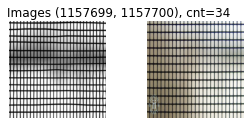

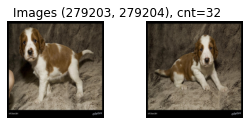

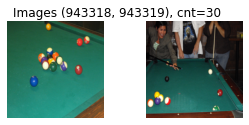

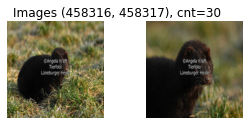

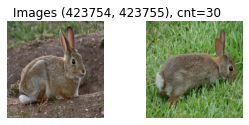

In [13]:
for pair, cnt in sorted_img_pairs[0:5]:
    img_i, img_j = pair.split('-')
    img_i, img_j = int(img_i), int(img_j)
    show_img_pair([img_i, img_j], title=f'Images ({img_i}, {img_j}), cnt={cnt}')

# 3. Learn embedding of images, that are not in the vocab

## 3-1. Load stimulus and get the vocab

In [14]:
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

def get_stimulus_path(model_nickname, topk_s):
    return f'/raid/NeuEvo/data/stimulus/{model_nickname}/data/stimulus-topk_s={topk_s}.json'

def load_stimulus(model_nickname, topk_s):
    p = get_stimulus_path(model_nickname, topk_s)
    data = load_json(p)
    return data

In [15]:
vgg19_stimulus = load_stimulus('vgg19_pretrained', 20)
vocab = {}
for layer in vgg19_stimulus:
    for neuron_stimuli in vgg19_stimulus[layer]:
        for img in neuron_stimuli:
            if img not in vocab:
                vocab[img] = 0
            vocab[img] += 1
len(vocab)

56475

## 3-2. Load image embedding of the base model

In [16]:
def draw_scatter(Xs):
    X = Xs[:,0]
    Y = Xs[:,1]

    plt.figure(figsize=(4, 4))
    plt.scatter(X, Y, s=3, alpha=0.2)
    plt.show()
    
def get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio):
    root = '/raid/NeuEvo/data/neuron_feature'
    return f'{root}/{model_nickname}/data/topk_s={topk_s}-ex_patch_size_ratio={ex_patch_size_ratio}'

def get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    d = get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio)
    paths = []
    for i in range(topk_s):
        paths.append(f'{d}/{layer}-{neuron_idx}-{i}.jpg')
    return paths

def load_img_from_path(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
                     
def show_ex_patch(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    img_ps = get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx)
    imgs = [load_img_from_path(img_path) for img_path in img_ps]
    title = f'{model_nickname}, {layer}-{neuron_idx}'
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=None)
    
def show_ex_patch_of_region(X, Y, X_2d, idx2id, model_nickname, topk_s=20, k=10):
    target = {}
    for i, vec in enumerate(X_2d):
        x = vec[0]
        y = vec[1]
        if X[0] <= x <= X[1] and Y[0] <= y <= Y[1]:
            target[i] = True

    neurons = [idx2id[i] for i in target]

    for neuron in neurons[:k]:
        layer, neuron_idx = neuron.split('-')
        neuron_idx = int(neuron_idx)
        show_ex_patch(model_nickname, topk_s, 0.3, layer, neuron_idx)

In [17]:
vgg19_img_emb_path = '/raid/NeuEvo/data/embedding/emb-vgg19_pretrained-topk_s=20-dim=30-lr_emb=0.05-num_emb_epochs=10000-num_emb_negs=3/data/emb-set-dim=30-lr_img_emb=10.0-thr_img_emb=0.001-max_iter_img_emb=10000-k=10/emb_nd/img_emb.txt'
base_img_emb = np.loadtxt(vgg19_img_emb_path)

In [18]:
# Deep copy of base_img_emb
img_emb = np.array(base_img_emb)
img_emb.shape

(1281167, 30)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


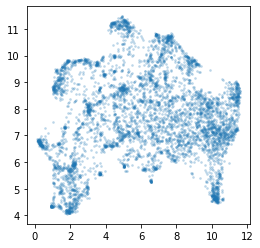

In [19]:
# Dimensionality reduction of the base model
neuron_emb_path = '/raid/NeuEvo/data/embedding/emb-vgg19_pretrained-topk_s=20-dim=30-lr_emb=0.05-num_emb_epochs=10000-num_emb_negs=3/data/emb/emb.json'
neuron_emb = load_json(neuron_emb_path)
N = len(neuron_emb)
dim = 30
X_vgg19 = np.zeros((N, dim))
idx2id_vgg19 = {}
for i, neuron in enumerate(neuron_emb):
    X_vgg19[i] = neuron_emb[neuron]
    idx2id_vgg19[i] = neuron

reducer = umap.UMAP(n_components=2)
reducer = reducer.fit(X_vgg19)
X_2d_vgg19 = reducer.embedding_

draw_scatter(X_2d_vgg19)

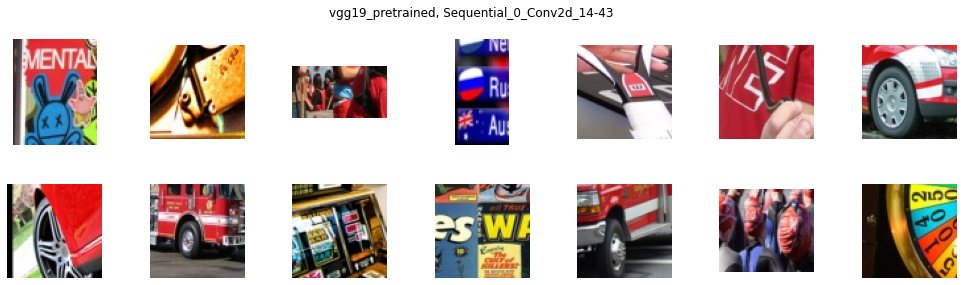

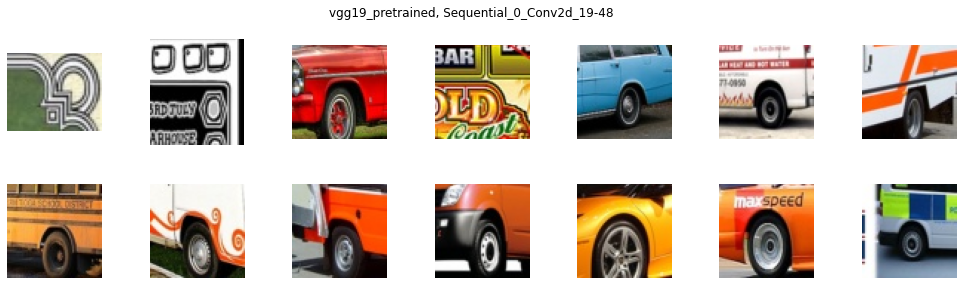

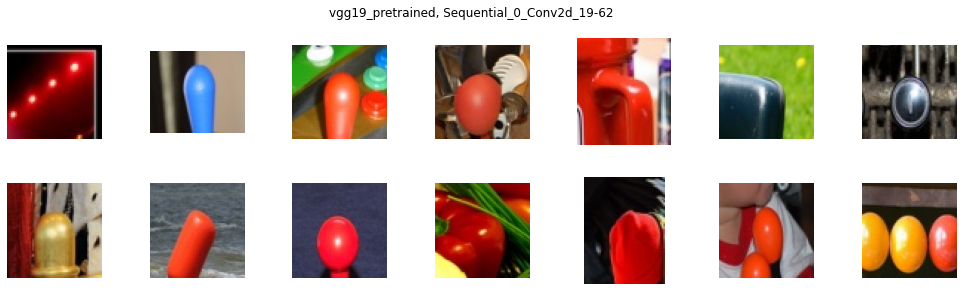

In [20]:
show_ex_patch_of_region([5, 7], [11, 12], X_2d_vgg19, idx2id_vgg19, 'vgg19_pretrained', 15, 3)

## 3-3. Learn image embedding

### 3-3-1. Before learning image embedding

In [21]:
def gen_avg_img_vec(imgs, i_X, dim):
    avg_v = np.zeros(dim)
    for img in imgs:
        avg_v += i_X[img]
    avg_v /= len(imgs)
    return avg_v
    
def project_vector(model_nickname, i_X, vocab):
    # Get stimulus
    stimulus = load_stimulus(model_nickname, 20)
    
    # Get number of neurons
    num_neurons = 0
    for layer in stimulus:
        num_neurons += len(stimulus[layer])
        
    # Get projection vector
    dim = 30
    p_X = np.zeros((num_neurons, dim))
    n = 0
    for layer in stimulus:
        for neuron_stimuli in stimulus[layer]:
            imgs = [img for img in neuron_stimuli if img in vocab]
            if len(imgs) > 0:
                p_X[n] = gen_avg_img_vec(imgs, i_X, dim)
            # p_X[n] = gen_avg_img_vec(neuron_stimuli, i_X, dim)
            n += 1
    return p_X

def project_vector_with_mapping(model_nickname, i_X, vocab):
    # Get stimulus
    stimulus = load_stimulus(model_nickname, 20)
    
    # Get number of neurons
    num_neurons = 0
    for layer in stimulus:
        num_neurons += len(stimulus[layer])
        
    # Get projection vector
    dim = 30
    p_X = np.zeros((num_neurons, dim))
    n = 0
    idx2id = {}
    for layer in stimulus:
        for neuron_idx, neuron_stimuli in enumerate(stimulus[layer]):
            imgs = [img for img in neuron_stimuli if img in vocab]
            if len(imgs) > 3:
                p_X[n] = gen_avg_img_vec(imgs, i_X, dim)
                idx2id[n] = f'{layer}-{neuron_idx}'
            # p_X[n] = gen_avg_img_vec(neuron_stimuli, i_X, dim)
            # idx2id[n] = f'{layer}-{neuron_idx}'
            n += 1
    return p_X, idx2id

def draw_projection(model_nickname, i_X, vocab):
    p_X = project_vector(model_nickname, i_X, vocab)
    p_X_2d = reduce_dim(p_X)
    draw_scatter(p_X_2d)

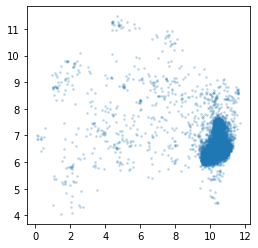

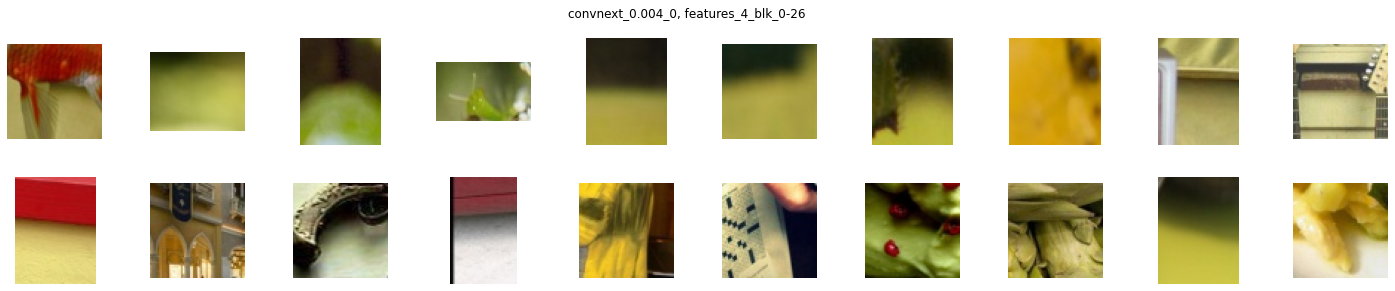

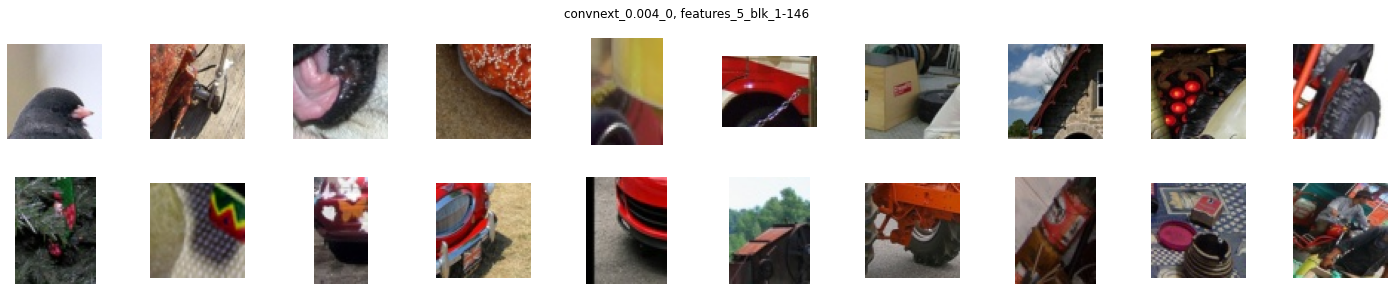

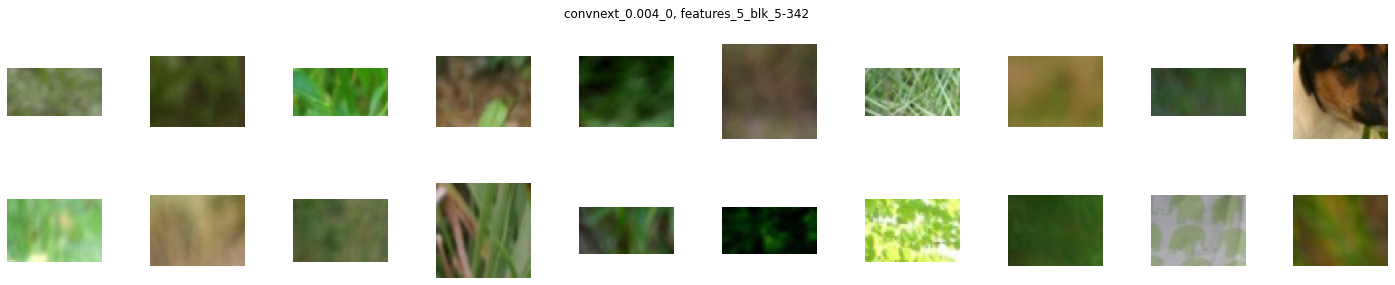

In [22]:
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_0', base_img_emb, vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)
show_ex_patch_of_region([1, 3], [4.5, 5.5], p_X_2d_convnext, idx2id_convnext, 'convnext_0.004_0', 20, 3)

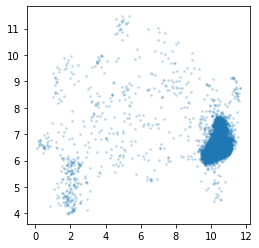

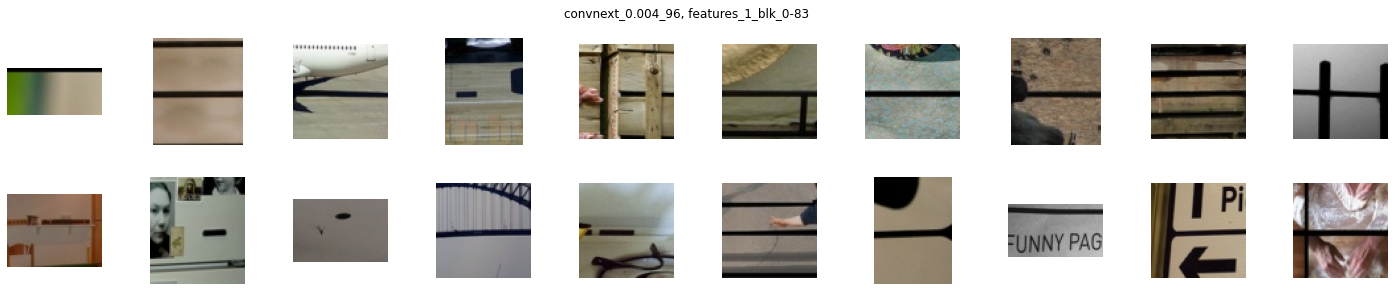

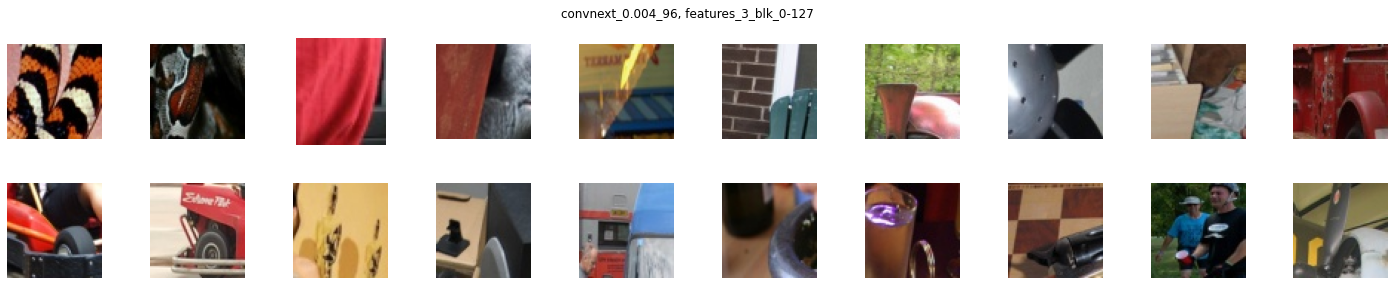

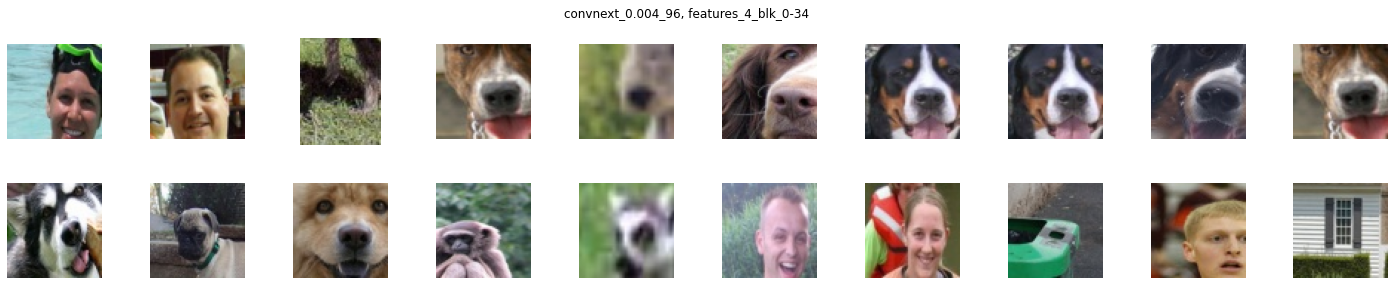

In [23]:
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_96', base_img_emb, vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)
show_ex_patch_of_region([1, 3], [4.5, 5.5], p_X_2d_convnext, idx2id_convnext, 'convnext_0.004_96', 20, 3)

### 3-3-2. After learning image embedding

In [24]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sample_rand_imgs(num_imgs, num):
    return np.random.choice(num_imgs, num, replace=False)

def sample_img_pair(img_pairs, num_samples):
    pairs = np.array(list(img_pairs.keys()))
    cnts = np.array(list(img_pairs.values()))
    probs = cnts / np.sum(cnts)
    sampled_pairs = np.random.choice(pairs, size=num_samples, p=probs)
    return sampled_pairs

In [45]:
def learn_image_embedding(vocab, added_vocab, img_emb, img_pairs, kwargs):
    # Hyperparameters
    num_epochs = kwargs['num_epochs']
    # num_sampled_pairs = kwargs['num_sampled_pairs']
    lr = kwargs['lr']
    R = kwargs['R']
    
    # Learn image embedding
    total = num_epochs * len(img_pairs)
    with tqdm(total=total) as pbar:
        for epoch in range(num_epochs):
            for pair in img_pairs:
                img_i, img_j = pair.split('-')
                img_i, img_j = int(img_i), int(img_j)
                cnt = img_pairs[pair]
                pbar.update(1)

                if (img_i not in vocab) and (img_j not in vocab):
                    continue

                # Get image vectors
                v_i = img_emb[img_i]
                v_j = img_emb[img_j]
                coeff = 1 - sigmoid(v_i.dot(v_j))

                # Update gradients for v_i
                if img_i not in vocab:
                    g_i = coeff * cnt * v_j
                    rand_imgs = sample_rand_imgs(num_imgs, R)
                    for img_r in rand_imgs:
                        v_r = img_emb[img_r]
                        g_i -= sigmoid(v_i.dot(v_r)) * v_r
                    img_emb[img_i] += lr * g_i
                    if img_i not in added_vocab:
                        added_vocab[img_i] = 0
                    added_vocab[img_i] += 1

                # Update gradients for v_j
                if img_j not in vocab:
                    g_j = coeff * cnt * v_i
                    rand_imgs = sample_rand_imgs(num_imgs, R)
                    for img_r in rand_imgs:
                        v_r = img_emb[img_r]
                        g_j -= sigmoid(v_j.dot(v_r)) * v_r
                    img_emb[img_j] += lr * g_j

                    if img_j not in added_vocab:
                        added_vocab[img_j] = 0
                    added_vocab[img_j] += 1
    return added_vocab, img_emb

In [46]:
print(f'Num img pairs: {len(img_pairs)}')
num_img_pairs = len(img_pairs)

Num img pairs: 23498703


### 3-3-3. Run one epoch

In [ ]:
kwargs = {
    'num_epochs': 1,
    'lr': 0.5,
    'R': 2
}

added_vocab = {}
added_vocab, img_emb = learn_image_embedding(vocab, added_vocab, img_emb, img_pairs, kwargs)

 54%|████████████████████████████████████████████████████▎                                           | 12796809/23498703 [6:19:08<4:27:02, 667.94it/s]

In [ ]:
new_vocab = {}
for img in vocab:
    plus = 0
    if img in added_vocab:
        plus = added_vocab[img]
    new_vocab[img] = vocab[img] + plus
    
for img in added_vocab:
    if img not in vocab:
        new_vocab[img] = added_vocab[img]
        
print(len(vocab))
print(len(added_vocab))
print(len(new_vocab))

In [ ]:
kwargs = {
    'num_epochs': 2000,
    'num_rep_epochs': 5,
    'num_sampled_pairs': 10000,
    'lr': 0.5,
    'R': 3
    # 'R': 0
}
added_vocab, img_emb = learn_image_embedding(vocab, added_vocab, img_emb, img_pairs, kwargs)

In [ ]:
new_vocab = {}
for img in vocab:
    plus = 0
    if img in added_vocab:
        plus = added_vocab[img]
    new_vocab[img] = vocab[img] + plus
    
for img in added_vocab:
    if img not in vocab:
        new_vocab[img] = added_vocab[img]
        
print(len(vocab))
print(len(added_vocab))
print(len(new_vocab))

In [ ]:
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_0', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_96', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
show_ex_patch_of_region([4, 8], [10, 12], p_X_2d_convnext, idx2id_convnext, 'convnext_0.004_96', 20, 20)

In [ ]:
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.02_17', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_96', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
new_vocab = {}
for img in vocab:
    plus = 0
    if img in added_vocab:
        plus = added_vocab[img]
    new_vocab[img] = vocab[img] + plus
    
for img in added_vocab:
    if img not in vocab:
        new_vocab[img] = added_vocab[img]
        
print(len(vocab))
print(len(added_vocab))
print(len(new_vocab))

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_96', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
new_vocab = {}
for img in vocab:
    plus = 0
    if img in added_vocab:
        plus = added_vocab[img]
    new_vocab[img] = vocab[img] + plus
    
for img in added_vocab:
    if img not in vocab:
        new_vocab[img] = added_vocab[img]
        
print(len(vocab))
print(len(added_vocab))
print(len(new_vocab))

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_96', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_0', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_0', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_96', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
show_ex_patch_of_region([5, 7], [11, 12], p_X_2d_convnext, idx2id_convnext, 'convnext_0.004_96', 20, 20)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_96', img_emb, vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)
# show_ex_patch_of_region([1, 3], [4.5, 5.5], p_X_2d_convnext, idx2id_convnext, 'convnext_0.004_96', 20, 3)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_0', img_emb, vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_0', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_0', img_emb, new_vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_96', img_emb, vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
# After num_epochs = 100, num_sampled_pairs = 100, ~5 mins
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_96', img_emb, vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
show_ex_patch_of_region([1, 3], [4.5, 5.5], p_X_2d_convnext, idx2id_convnext, 'convnext_0.004_96', 20, 10)

In [ ]:
def gen_avg_img_vec(imgs, i_X, dim):
    avg_v = np.zeros(dim)
    for img in imgs:
        avg_v += i_X[img]
    avg_v /= len(imgs)
    return avg_v


    
def reduce_dim(X):
    reducer = umap.UMAP(n_components=2)
    reducer = reducer.fit(X)
    return reducer.embedding_

def project_vector(model_nickname, i_X, vocab):
    # Get stimulus
    stimulus = load_stimulus(model_nickname, 20)
    
    # Get number of neurons
    num_neurons = 0
    for layer in stimulus:
        num_neurons += len(stimulus[layer])
        
    # Get projection vector
    dim = 30
    p_X = np.zeros((num_neurons, dim))
    n = 0
    for layer in stimulus:
        for neuron_stimuli in stimulus[layer]:
            imgs = [img for img in neuron_stimuli if img in vocab]
            if len(imgs) > 0:
                p_X[n] = gen_avg_img_vec(imgs, i_X, dim)
            n += 1
    return p_X

def project_vector_with_mapping(model_nickname, i_X, vocab):
    # Get stimulus
    stimulus = load_stimulus(model_nickname, 20)
    
    # Get number of neurons
    num_neurons = 0
    for layer in stimulus:
        num_neurons += len(stimulus[layer])
        
    # Get projection vector
    dim = 30
    p_X = np.zeros((num_neurons, dim))
    n = 0
    idx2id = {}
    for layer in stimulus:
        for neuron_idx, neuron_stimuli in enumerate(stimulus[layer]):
            imgs = [img for img in neuron_stimuli if img in vocab]
            if len(imgs) > 0:
                p_X[n] = gen_avg_img_vec(imgs, i_X, dim)
                idx2id[n] = f'{layer}-{neuron_idx}'
            n += 1
    return p_X, idx2id

def draw_projection(model_nickname, i_X, vocab):
    p_X = project_vector(model_nickname, i_X, vocab)
    p_X_2d = reduce_dim(p_X)
    draw_scatter(p_X_2d)

In [ ]:
def get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio):
    root = '/raid/NeuEvo/data/neuron_feature'
    return f'{root}/{model_nickname}/data/topk_s={topk_s}-ex_patch_size_ratio={ex_patch_size_ratio}'

def get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    d = get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio)
    paths = []
    for i in range(topk_s):
        paths.append(f'{d}/{layer}-{neuron_idx}-{i}.jpg')
    return paths

def load_img_from_path(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
                     
def show_ex_patch(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    img_ps = get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx)
    imgs = [load_img_from_path(img_path) for img_path in img_ps]
    title = f'{model_nickname}, {layer}-{neuron_idx}'
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=None)

In [ ]:
draw_projection('vgg19_pretrained', vgg19_img_emb, vocab)

In [ ]:
neuron_emb_path = '/raid/NeuEvo/data/embedding/emb-vgg19_pretrained-topk_s=20-dim=30-lr_emb=0.05-num_emb_epochs=10000-num_emb_negs=3/data/emb/emb.json'
neuron_emb = load_json(neuron_emb_path)
N = len(neuron_emb)
X_vgg19 = np.zeros((N, dim))
for i, neuron in enumerate(neuron_emb):
    X_vgg19[i] = neuron_emb[neuron]

In [ ]:
reducer = umap.UMAP(n_components=2)
reducer = reducer.fit(X_vgg19)

### VGG16_0.01

In [ ]:
p_X = project_vector('vgg16_0.01_0', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('vgg16_0.01_21', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('vgg16_0.01_207', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X_vgg16, idx2id_vgg16 = project_vector_with_mapping('vgg16_0.01_207', vgg19_img_emb, vocab)
p_X_2d_vgg16 = reducer.transform(p_X_vgg16)
draw_scatter(p_X_2d_vgg16)

In [ ]:
target = {}
for i, vec in enumerate(p_X_2d_vgg16):
    x = vec[0]
    y = vec[1]
    if 2 <= x <= 3 and 4.5 <= y <= 5.5:
        target[i] = True
        
neurons = [idx2id_vgg16[i] for i in target]

In [ ]:
for neuron in neurons[:10]:
    layer, neuron_idx = neuron.split('-')
    neuron_idx = int(neuron_idx)
    show_ex_patch('vgg16_0.01_207', 20, 0.3, layer, neuron_idx)

### VGG16_0.05

In [ ]:
p_X = project_vector('vgg16_0.05_0', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('vgg16_0.05_3', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('vgg16_0.05_12', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('vgg16_0.05_13', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('vgg16_0.05_14', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('vgg16_0.05_54', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

### ConvNeXt_0.004

In [ ]:
p_X = project_vector('convnext_0.004_0', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)
# 10%

In [ ]:
p_X_convnext, idx2id_convnext = project_vector_with_mapping('convnext_0.004_0', vgg19_img_emb, vocab)
p_X_2d_convnext = reducer.transform(p_X_convnext)
draw_scatter(p_X_2d_convnext)

In [ ]:
target = {}
for i, vec in enumerate(p_X_2d_convnext):
    x = vec[0]
    y = vec[1]
    if 1.8 <= x <= 2.2 and 6 <= y <= 7:
        target[i] = True
        
neurons = [idx2id_convnext[i] for i in target]

for neuron in neurons[:10]:
    layer, neuron_idx = neuron.split('-')
    neuron_idx = int(neuron_idx)
    show_ex_patch('convnext_0.004_0', 20, 0.3, layer, neuron_idx)

In [ ]:
p_X = project_vector('convnext_0.004_1', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)
# 36%

In [ ]:
p_X = project_vector('convnext_0.004_3', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)
54%

In [ ]:
p_X = project_vector('convnext_0.004_91', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_0.004_96', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X_convnext_96, idx2id_convnext_96 = project_vector_with_mapping('convnext_0.004_96', vgg19_img_emb, vocab)
p_X_2d_convnext_96 = reducer.transform(p_X_convnext_96)
draw_scatter(p_X_2d_convnext_96)

In [ ]:
target = {}
for i, vec in enumerate(p_X_2d_convnext_96):
    x = vec[0]
    y = vec[1]
    if 1.8 <= x <= 2.2 and 6 <= y <= 7:
        target[i] = True
        
neurons = [idx2id_convnext_96[i] for i in target]

for neuron in neurons[:10]:
    layer, neuron_idx = neuron.split('-')
    neuron_idx = int(neuron_idx)
    show_ex_patch('convnext_0.004_96', 20, 0.3, layer, neuron_idx)

In [ ]:
p_X = project_vector('convnext_0.004_lambda0_0', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_0.004_1', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_0.02_0', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_0.02_9', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_0.02_10', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_0.02_13', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_0.02_14', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_0.02_17', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_0.02_19', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('inception_v3_1.5_0', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('inception_v3_1.5_4', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('inception_v3_1.5_70', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('inception_v3_1.5_71', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('inception_v3_1.5_72', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('inception_v3_1.5_73', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('inception_v3_1.5_100', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('vgg19_pretrained', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

In [ ]:
p_X = project_vector('convnext_pretrained', vgg19_img_emb, vocab)
p_X_2d = reducer.transform(p_X)
draw_scatter(p_X_2d)

# 2. Can layer activation find a group of similar images?

## 2-1. Showing training images given image indices

In [ ]:
raw_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

raw_training_datasets = datasets.ImageFolder(
    '../../../../ILSVRC2012/train',
    raw_data_transform
)

def show_imgs(img_idxs):
    for img_idx in img_idxs:
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        plt.title(f'img: {img_idx}')
        plt.imshow(img)
        plt.show()
        
def show_np_imgs_2_rows(imgs, title=None, subplot_titles=None):
    # Create figure
    nrows = 2
    ncols = len(imgs) // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    # Create subplots
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = int(i / ncols)
        col = i - row * ncols
        ax[row, col].imshow(img) 
        ax[row, col].set_axis_off()
        if subplot_titles is not None:
            ax[row, col].set_title(subplot_titles[i])

    # Title
    if title is not None:
        fig.suptitle(title, y=1.06)
        
    # Show the final plot
    plt.show()
        
def show_imgs_2_rows(img_idxs, title=None):
    # Images
    imgs = []
    subplot_titles = []
    for i, img_idx in enumerate(img_idxs):
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        imgs.append(img)
        subplot_titles.append(f'{i}-th img: {img_idx}')
        
    # Show images
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=subplot_titles)

## 2-2. Pick an image and find the most similar images based on the cosine similarity

In [ ]:
def cos_sim(v, w):
    n_v = np.linalg.norm(v)
    n_w = np.linalg.norm(w)
    if n_v <= 0 or n_w <= 0:
        return 0
    return v.dot(w) / (n_v * n_w)

In [ ]:
# Sample an image
num_imgs = img_emb.shape[0]
sampled_img_idx = np.random.choice(num_imgs)
# print(f'Sampled image index: {sampled_img_idx}')
sampled_img_idx = 712344
show_imgs([sampled_img_idx])

In [ ]:
# Find top 10 similar images
sim_d = {}
sampled_img_v = img_emb[sampled_img_idx]
for img_idx, img_v in enumerate(img_emb):
    sim_d[img_idx] = cos_sim(sampled_img_v, img_v)

sorted_sim = sorted(sim_d.items(), key=lambda x:x[1], reverse=True)
top10_imgs = {t[0]: t[1] for t in sorted_sim[1:11]}

show_imgs_2_rows(top10_imgs)

## 2-3. Pick an image and find the most similar images based on K-means clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
num_imgs = img_emb.shape[0]
num_sampled_imgs = int(0.1 * num_imgs)
sampled_imgs = np.random.choice(num_imgs, num_sampled_imgs, replace=False)

sampled_img_emb = img_emb[sampled_imgs]
sampled_img_emb.shape

In [ ]:
tic = time()
kmeans = KMeans(n_clusters=100, random_state=0).fit(sampled_img_emb)
toc = time()
print(f'K-means fitting: {toc - tic:.2f} sec')

In [ ]:
kmeans_labels = kmeans.labels_

img_clusters = {}
for img_idx, label in enumerate(kmeans_labels):
    if label not in img_clusters:
        img_clusters[label] = {}
    img_clusters[label][img_idx] = True
    
for label in img_clusters:
    img_clusters[label] = list(img_clusters[label].keys())

In [ ]:
sorted_img_clusters = sorted(img_clusters.items(), key=lambda x: len(x[1]), reverse=True)
for k, v in sorted_img_clusters:
    print(f'Cluster-{k:02d}, {len(v)} imgs')

In [ ]:
for cluster_label, cluster_imgs in sorted_img_clusters:
    np.random.shuffle(cluster_imgs)
    show_imgs_2_rows(cluster_imgs[:10], title=f'cluster-{cluster_label}')

## 2-4. Pick an image and find the most similar images based on DBSCAN clustering

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
num_imgs = img_emb.shape[0]
num_sampled_imgs = int(0.1 * num_imgs)
sampled_imgs = np.random.choice(num_imgs, num_sampled_imgs, replace=False)

sampled_img_emb = img_emb[sampled_imgs]
sampled_img_emb.shape

In [ ]:
tic = time()
dbscan = DBSCAN(min_samples=2, eps=0.1).fit(sampled_img_emb)
toc = time()
print(f'DBSCAN fitting: {toc - tic:.2f} sec')

In [ ]:
dbscan_labels = dbscan.labels_

img_clusters = {}
for img_idx, label in enumerate(dbscan_labels):
    if label not in img_clusters:
        img_clusters[label] = {}
    img_clusters[label][img_idx] = True
    
for label in img_clusters:
    img_clusters[label] = list(img_clusters[label].keys())

In [ ]:
sorted_img_clusters[0][-1][:10]

In [ ]:
show_imgs(sorted_img_clusters[1][-1])

## 2-5. Can we sample pairs quickly?

In [ ]:
from tqdm import tqdm

In [ ]:
class TopKKeeper:
    """
    Keep k (key, val, content) paris, where they are sorted in the descending 
    order. If a new inserted pair (key', val', content') has lower value than 
    the minimum value of the item (i.e., val' < min val), it won't be inserted.
    Content is optional.
    """
    
    def __init__(self, k):
        self.k = k
        self.keys = []
        self.vals = []
        self.contents = []


    def will_insert(self, val):
        if len(self.vals) < self.k:
            return True
        elif self.vals[-1] < val:
            return True
        return False

        
    def insert(self, val, key=None, content=None):
        # Check whether we want to insert the item or not
        if not self.will_insert(val):
            return
        
        # Insert
        reach_end = True
        for i, e in enumerate(self.vals):
            if e < val:
                if key is not None:
                    self.keys = self.keys[:i] + [key] + self.keys[i:]
                    self.keys = self.keys[:self.k]

                self.vals = self.vals[:i] + [val] + self.vals[i:]
                self.vals = self.vals[:self.k]

                if content is not None:
                    self.contents = \
                        self.contents[:i] + [content] + self.contents[i:]
                    self.contents = self.contents[:self.k]

                reach_end = False
                break
        if reach_end:
            if key is not None:
                self.keys.append(key)
                self.keys = self.keys[:self.k]

            self.vals.append(val)
            self.vals = self.vals[:self.k]

            if content is not None:
                self.contents.append(content)
                self.contents = self.contents[:self.k]


In [ ]:
neigbor_imgs = {}
with tqdm(total=len(img_emb)) as pbar:
    for img_i, v_i in enumerate(img_emb):
        topk_keeper = TopKKeeper(10)
        for img_j, v_j in enumerate(img_emb):
            if img_i == img_j:
                continue
            s = cos_sim(v_i, v_j)
            topk_keeper.insert(s, key=img_j)
        similar_imgs = topk_keeper.keys
        neigbor_imgs[img_i] = similar_imgs[:]
        pbar.update(1)

In [ ]:
for img_idx in neigbor_imgs:
    show_imgs([img_idx])
    show_imgs_2_rows(neigbor_imgs[img_idx])

# 3. Can image embedding (from layer activation) approximate the similarity between neurons in different models?

# 3-1. Load stimulus

In [ ]:
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

def get_stimulus_path(model_nickname, topk_s):
    return f'/raid/NeuEvo/data/stimulus/{model_nickname}/data/stimulus-topk_s={topk_s}.json'

def load_stimulus(model_nickname, topk_s):
    p = get_stimulus_path(model_nickname, topk_s)
    data = load_json(p)
    return data

In [ ]:
model_nickname_1 = 'vgg19_pretrained'
model_nickname_2 = 'convnext_0.004_96'

topk_s = 20

stimulus_1 = load_stimulus(model_nickname_1, topk_s)
stimulus_2 = load_stimulus(model_nickname_2, topk_s)

## 3-2. Sample a neuron from model 1

In [ ]:
def sample_layer(stimulus):
    layers = list(stimulus.keys())
    sampled_layer = np.random.choice(layers)
    return sampled_layer

def sample_neuron(stimulus):
    sampled_layer = sample_layer(stimulus)
    num_neurons = len(stimulus[sampled_layer])
    sampled_neuron = np.random.choice(num_neurons)
    neuron_id = f'{sampled_layer}-{sampled_neuron}'
    return neuron_id

In [ ]:
def get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio):
    root = '/raid/NeuEvo/data/neuron_feature'
    return f'{root}/{model_nickname}/data/topk_s={topk_s}-ex_patch_size_ratio={ex_patch_size_ratio}'

def get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    d = get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio)
    paths = []
    for i in range(topk_s):
        paths.append(f'{d}/{layer}-{neuron_idx}-{i}.jpg')
    return paths

def load_img_from_path(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
                     
def show_ex_patch(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    img_ps = get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx)
    imgs = [load_img_from_path(img_path) for img_path in img_ps]
    title = f'{model_nickname}, {layer}-{neuron_idx}'
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=None)

In [ ]:
sampled_neuron_id_1 = sample_neuron(stimulus_1)
sampled_neuron_id_1

In [ ]:
ex_patch_size_ratio = 0.3
sampled_neuron_layer, sampled_neuron_idx = sampled_neuron_id_1.split('-')
sampled_neuron_idx = int(sampled_neuron_idx)
show_ex_patch(model_nickname_1, 15, ex_patch_size_ratio, sampled_neuron_layer, sampled_neuron_idx)

## 3-3. Find neurons in model 2 that are similar to the sampled neuron in model 1

In [ ]:
class TopKKeeper:
    """
    Keep k (key, val, content) paris, where they are sorted in the descending 
    order. If a new inserted pair (key', val', content') has lower value than 
    the minimum value of the item (i.e., val' < min val), it won't be inserted.
    Content is optional.
    """
    
    def __init__(self, k):
        self.k = k
        self.keys = []
        self.vals = []
        self.contents = []


    def will_insert(self, val):
        if len(self.vals) < self.k:
            return True
        elif self.vals[-1] < val:
            return True
        return False

        
    def insert(self, val, key=None, content=None):
        # Check whether we want to insert the item or not
        if not self.will_insert(val):
            return
        
        # Insert
        reach_end = True
        for i, e in enumerate(self.vals):
            if e < val:
                if key is not None:
                    self.keys = self.keys[:i] + [key] + self.keys[i:]
                    self.keys = self.keys[:self.k]

                self.vals = self.vals[:i] + [val] + self.vals[i:]
                self.vals = self.vals[:self.k]

                if content is not None:
                    self.contents = \
                        self.contents[:i] + [content] + self.contents[i:]
                    self.contents = self.contents[:self.k]

                reach_end = False
                break
        if reach_end:
            if key is not None:
                self.keys.append(key)
                self.keys = self.keys[:self.k]

            self.vals.append(val)
            self.vals = self.vals[:self.k]

            if content is not None:
                self.contents.append(content)
                self.contents = self.contents[:self.k]

In [ ]:
def get_avg_img_emb(stimuli, dim, img_emb):
    avg_v = np.zeros(dim)
    for img in stimuli:
        v = img_emb[img]
        avg_v += v
    avg_v = avg_v / len(stimuli)
    return avg_v

In [ ]:
sampled_neuron_stimuli = stimulus_1[sampled_neuron_layer][sampled_neuron_idx]
sampled_neuron_v = get_avg_img_emb(sampled_neuron_stimuli, dim, img_emb)

dim = 30
topk_keeper = TopKKeeper(10)
for layer in stimulus_2:
    for neuron_idx, neuron_stimuli in enumerate(stimulus_2[layer]):
        avg_v = get_avg_img_emb(neuron_stimuli, dim, img_emb)
        sim = cos_sim(sampled_neuron_v, avg_v)
        topk_keeper.insert(sim, key=f'{layer}-{neuron_idx}')
        
print(topk_keeper.keys)
print(topk_keeper.vals)

In [ ]:
similar_neurons = topk_keeper.keys
topk_s = 20
for neuron in similar_neurons:
    layer, idx = neuron.split('-')
    idx = int(idx)
    show_ex_patch(
        model_nickname_2, 
        topk_s, 
        ex_patch_size_ratio, 
        layer, 
        idx
    )

In [ ]:
for layer in stimulus_1.keys():
    print(layer)